### Generate Data

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import sklearn.model_selection as train_test_split
import sklearn.linear_model as LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score


np.random.seed(42)

number_samples = 3000

# categorical features
industry = ['Automotive', 'Finance', 'Healthcare', 'Retail', 'Technology', 'Government', 'Education', 'Manufacturing', 'Food and Beverage', 'Energy']
weighted_industry = np.random.rand(10)
weighted_industry = weighted_industry / weighted_industry.sum()
feature_use = ['low', 'medium', 'high']

def random_dates(start, end, n):
    business_days = pd.date_range(start=start, end=end, freq='B')
    return np.random.choice(business_days, size=n, replace=True)

random_dates(pd.to_datetime('2015-01-01'), pd.to_datetime('2023-01-01'), 5)  # Example usage

array(['2021-06-17T00:00:00.000000000', '2017-12-13T00:00:00.000000000',
       '2020-10-22T00:00:00.000000000', '2019-08-29T00:00:00.000000000',
       '2018-08-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [109]:
customer_data = {
    'customer_id': np.arange(1, number_samples + 1),
    'customer_size': np.random.normal(1500,250, number_samples).astype(int),
    'annual_revenue': np.random.normal(1000000, 200000, number_samples).round(2),
    'industry': np.random.choice(industry, number_samples, p=weighted_industry),
    'c_level_engagement': np.random.choice(feature_use, number_samples, p=[0.6, 0.2, 0.2]),
    'open_deals': np.random.binomial(1, 0.2, number_samples),
    'customer_sign_up_date': random_dates(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-12-31'), number_samples),
    'amount_ARR_cloud': np.random.normal(50000, 10000, number_samples).round(2),
    'amount_ARR_on_prem': np.random.normal(30000, 8000, number_samples).round(2),
    'feature_1_usage': np.random.choice(feature_use, number_samples, p=[0.5, 0.3, 0.2]),
    'feature_2_usage': np.random.choice(feature_use, number_samples, p=[0.4, 0.4, 0.2]),
    'feature_3_usage': np.random.choice(feature_use, number_samples, p=[0.3, 0.5, 0.2]),
    'churned': np.random.binomial(1, 0.17, number_samples)
}

In [ ]:
df_customers = pd.DataFrame(customer_data)
df_customers['next_renewal_date'] = df_customers['customer_sign_up_date'] + pd.DateOffset(years=3)
df_customers['last_qbr_date'] = df_customers.apply(lambda df: random_dates(df['customer_sign_up_date'], 
                                                            df['next_renewal_date'], 1)[0], 
                                                            axis=1)
df_customers['amount_ARR_total'] = df_customers['amount_ARR_cloud'] + df_customers['amount_ARR_on_prem']
df_customers['customer_age'] = (pd.Timestamp.now() - df_customers['customer_sign_up_date']).dt.days // 30
df_customers.head()

,customer_id,customer_size,annual_revenue,industry,c_level_engagement,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,feature_1_usage,feature_2_usage,feature_3_usage,churned,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age
0,1,1270,1197736.11,Technology,medium,1,2020-05-19,46076.12,25516.91,low,medium,low,0,2023-05-19,2021-09-01,71593.03,67
1,2,1468,1063621.01,Food and Beverage,high,0,2021-06-30,49644.51,31009.35,low,low,medium,0,2024-06-30,2022-02-10,80653.86,53
2,3,997,1086966.24,Government,high,1,2013-06-27,54343.12,33220.74,low,high,medium,0,2016-06-27,2015-08-25,87563.86,151
3,4,1376,935449.79,Government,low,0,2011-09-12,44690.58,34434.24,low,high,medium,0,2014-09-12,2012-04-18,79124.82,172
4,5,1598,1135527.94,Retail,high,1,2010-02-23,57364.01,29314.18,low,high,medium,0,2013-02-23,2010-03-11,86678.19,191


In [ ]:
df_customers[['customer_sign_up_date','next_renewal_date','last_qbr_date']].head()

,customer_sign_up_date,next_renewal_date,last_qbr_date
0,2020-05-19,2023-05-19,2021-09-01
1,2021-06-30,2024-06-30,2022-02-10
2,2013-06-27,2016-06-27,2015-08-25
3,2011-09-12,2014-09-12,2012-04-18
4,2010-02-23,2013-02-23,2010-03-11


In [ ]:
df_customers['days_between_renewal_and_qbr'] = (df_customers['next_renewal_date'] - df_customers['last_qbr_date']).dt.days

# EDA

In [ ]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id                   3000 non-null   int32         
 1   customer_size                 3000 non-null   int32         
 2   annual_revenue                3000 non-null   float64       
 3   industry                      3000 non-null   object        
 4   c_level_engagement            3000 non-null   object        
 5   open_deals                    3000 non-null   int32         
 6   customer_sign_up_date         3000 non-null   datetime64[ns]
 7   amount_ARR_cloud              3000 non-null   float64       
 8   amount_ARR_on_prem            3000 non-null   float64       
 9   feature_1_usage               3000 non-null   object        
 10  feature_2_usage               3000 non-null   object        
 11  feature_3_usage               

In [ ]:
df_customers.describe()

,customer_id,customer_size,annual_revenue,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,churned,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age,days_between_renewal_and_qbr
count,3000.000000,3000.000000,3.000000e+03,3000.000000,3000,3000.000000,3000.000000,3000.000000,3000,3000,3000.000000,3000.000000,3000.000000
mean,1500.500000,1509.700333,9.998519e+05,0.203667,2016-08-08 23:16:19.200000,49914.682613,29968.902283,0.164333,2019-08-09 17:30:14.400000,2018-02-15 18:34:04.800000,79883.584897,112.623000,539.955667
min,1.000000,653.000000,3.321000e+05,0.000000,2010-01-04 00:00:00,17578.440000,-5828.180000,0.000000,2013-01-04 00:00:00,2010-02-11 00:00:00,40662.410000,35.000000,0.000000
25%,750.750000,1336.000000,8.654773e+05,0.000000,2013-06-03 18:00:00,43273.255000,24606.742500,0.000000,2016-06-03 18:00:00,2014-10-27 00:00:00,71509.095000,72.000000,269.000000
50%,1500.500000,1513.000000,9.983849e+05,0.000000,2016-08-08 00:00:00,49997.045000,29761.875000,0.000000,2019-08-08 00:00:00,2018-03-07 00:00:00,79915.095000,113.000000,537.000000
75%,2250.250000,1684.000000,1.137634e+06,0.000000,2019-12-05 00:00:00,56610.860000,35296.872500,0.000000,2022-12-05 00:00:00,2021-05-07 18:00:00,88032.395000,151.000000,806.250000
max,3000.000000,2373.000000,1.810510e+06,1.000000,2022-12-30 00:00:00,82428.320000,63183.160000,1.000000,2025-12-30 00:00:00,2025-10-23 00:00:00,128048.670000,193.000000,1096.000000
std,866.169729,254.689572,1.993911e+05,0.402791,NaN,9782.640269,7934.161586,0.370640,NaN,NaN,12656.231054,45.701624,314.231308


In [ ]:
categorical_features = ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']

for col in categorical_features:
    df_customers[col] = pd.Categorical(df_customers[col], 
                                                    categories= feature_use, 
                                                    ordered=True)


In [ ]:
for col in categorical_features:
    print(f'{col}: {round(df_customers[col].cat.codes.mean(), 2)}')

c_level_engagement: 0.61
feature_1_usage: 0.72
feature_2_usage: 0.81
feature_3_usage: 0.88


In [ ]:
df_customers.isna().sum()

customer_id                     0
customer_size                   0
annual_revenue                  0
industry                        0
c_level_engagement              0
open_deals                      0
customer_sign_up_date           0
amount_ARR_cloud                0
amount_ARR_on_prem              0
feature_1_usage                 0
feature_2_usage                 0
feature_3_usage                 0
churned                         0
next_renewal_date               0
last_qbr_date                   0
amount_ARR_total                0
customer_age                    0
days_between_renewal_and_qbr    0
dtype: int64

In [ ]:
df_customers.duplicated().sum()

0

In [ ]:
# Numeric columns (int, float, nullable types)
numeric_features = df_customers.select_dtypes(include=['int64', 'float64']).columns.to_list()

# Categorical columns that are explicitly dtype "category"
categorical_features = df_customers.select_dtypes(include=['category']).columns.tolist()

# Nominal (string) features — typical object columns
nominal_categorical_features = df_customers.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Nominal categorical features:", nominal_categorical_features)

Numeric features: ['annual_revenue', 'amount_ARR_cloud', 'amount_ARR_on_prem', 'amount_ARR_total', 'customer_age', 'days_between_renewal_and_qbr']
Categorical features: ['c_level_engagement', 'feature_1_usage', 'feature_2_usage', 'feature_3_usage']
Nominal categorical features: ['industry']


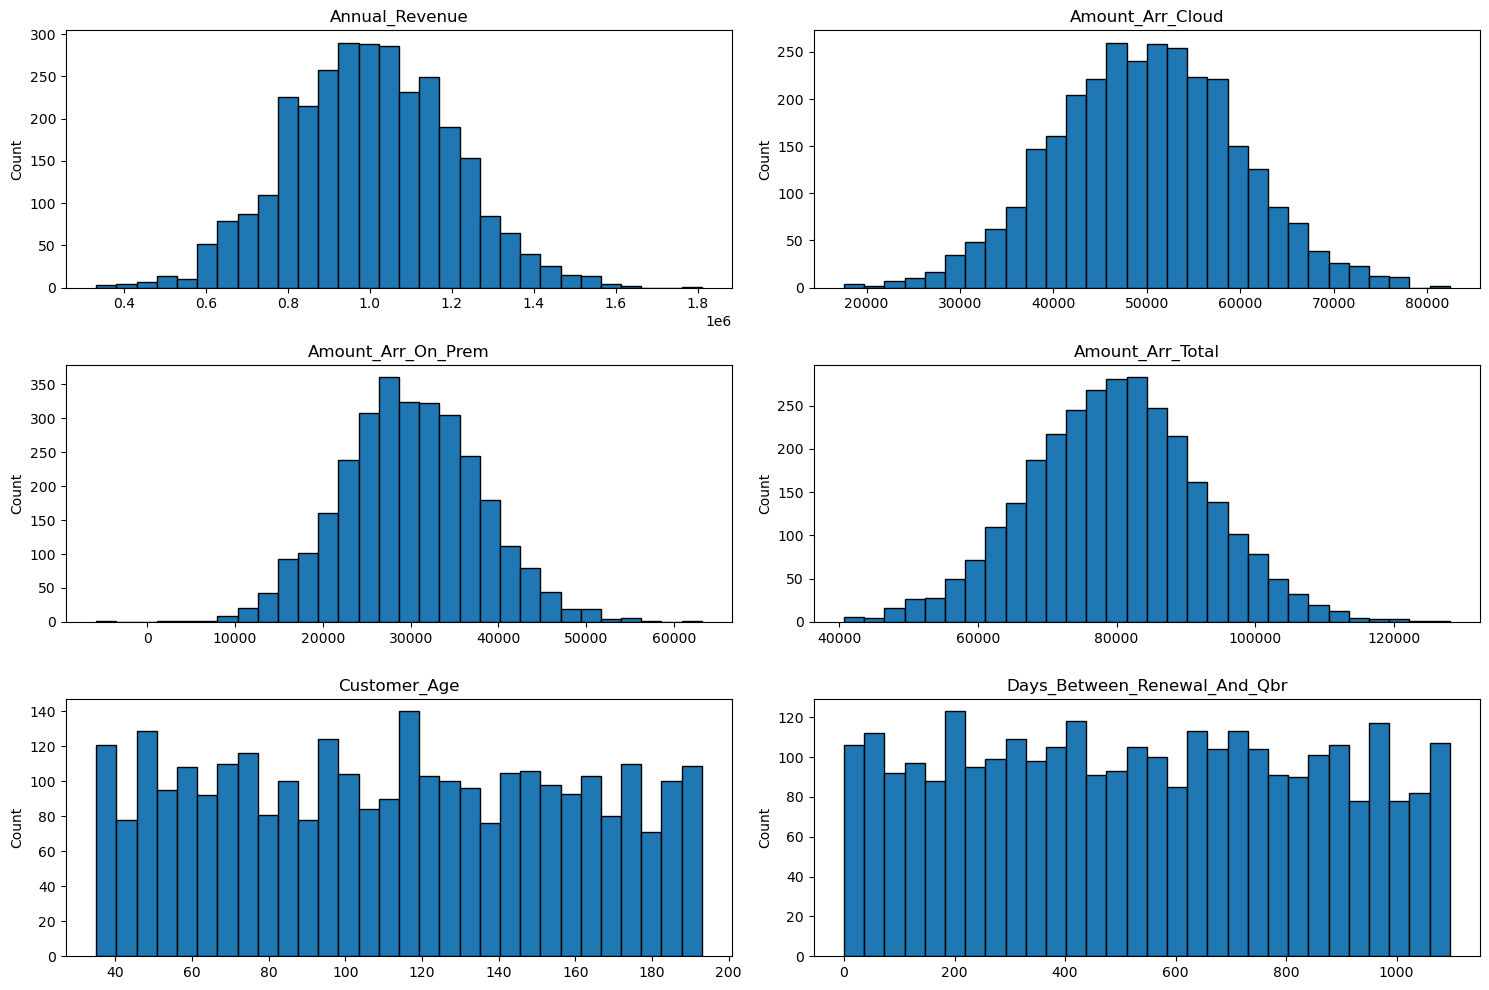

In [ ]:
numeric_features = df_customers.select_dtypes(include=['int64', 'float64']).columns

ax = df_customers[numeric_features].hist(
    figsize=(15, 10),
    bins=30,
    edgecolor='black',
    grid=False
)

# Make titles cleaner + adjust layout
for row in ax:
    for subplot in row:
        subplot.set_title(subplot.get_title().title())
        subplot.set_xlabel(subplot.get_xlabel().replace('_', ' ').title())
        subplot.set_ylabel("Count")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix for Numeric Features')

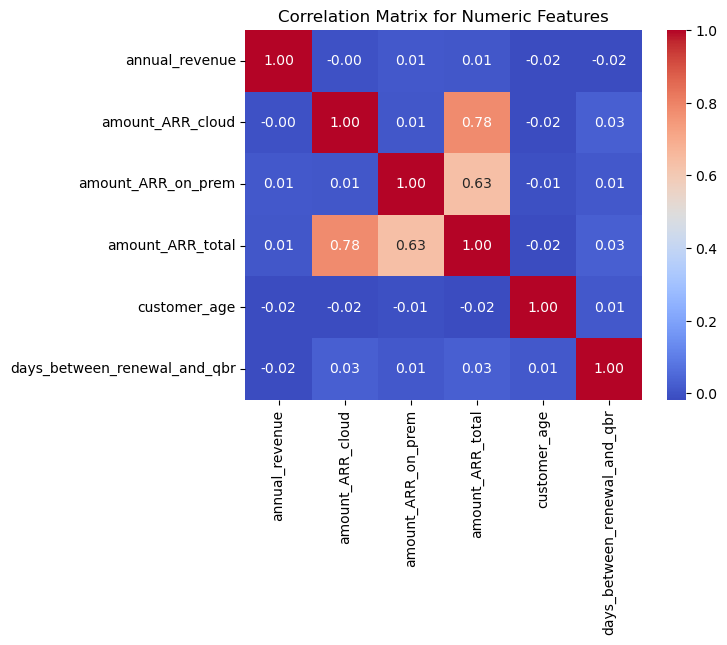

In [ ]:
df_customers[numeric_features].corr()
sns.heatmap(df_customers[numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')

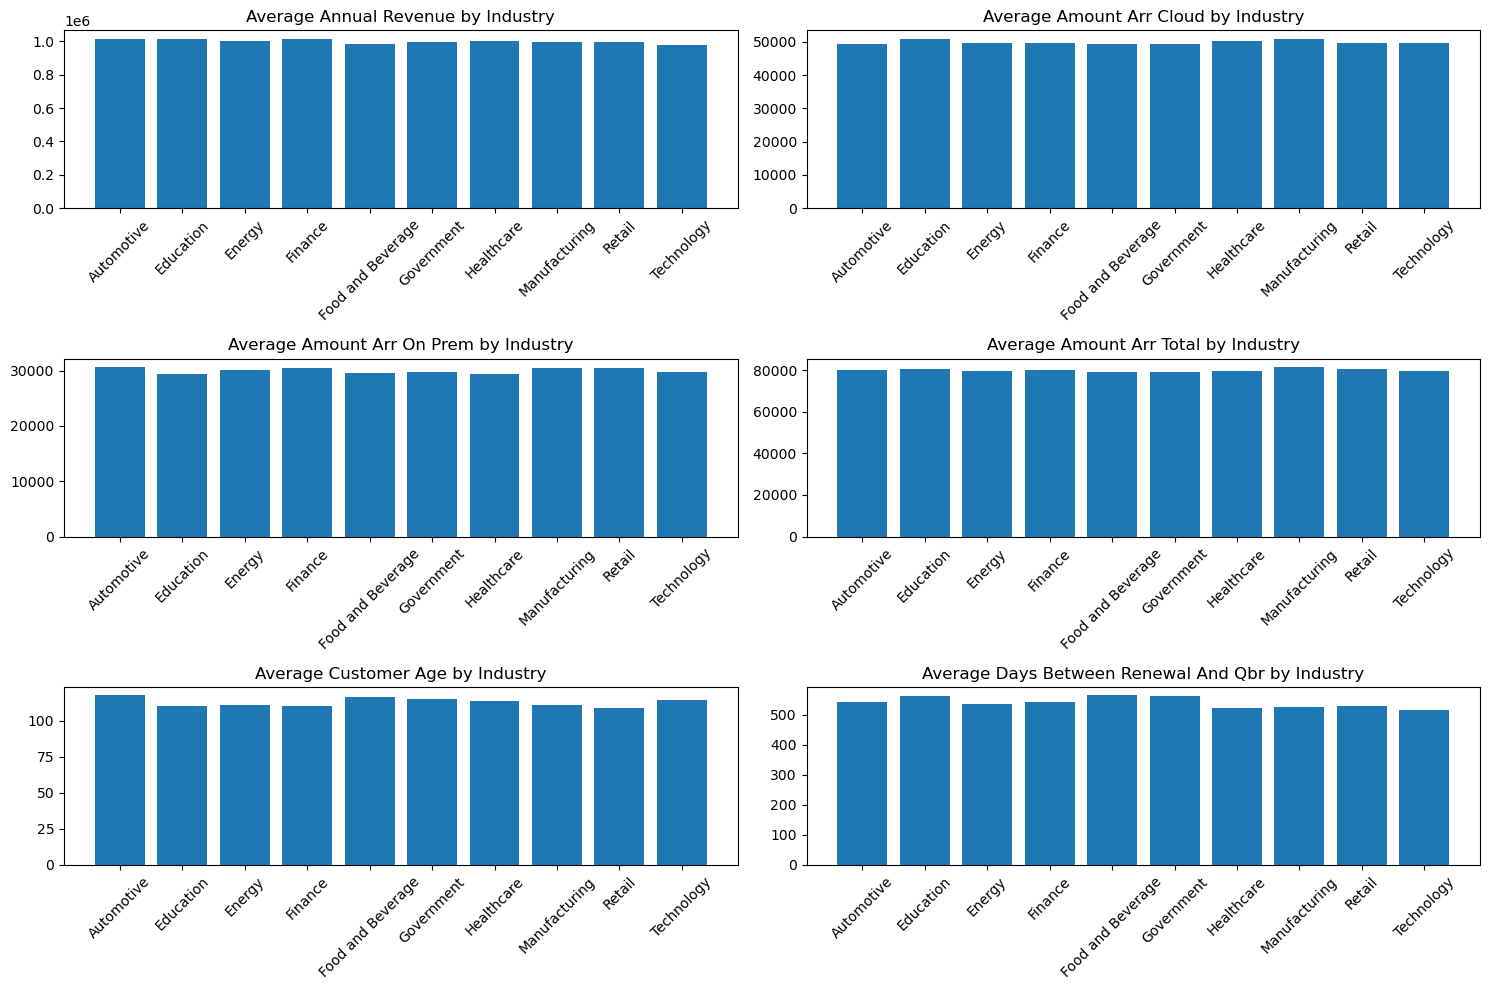

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

all_axes = ax.flatten()

for num_feat, subplot in zip(numeric_features, all_axes):

    industry_group = df_customers.groupby('industry')[num_feat].mean()

    subplot.bar(x=industry_group.index, height=industry_group.values)
    
    subplot.set_title(f'Average {num_feat.replace("_", " ").title()} by Industry')
    subplot.tick_params(axis='x', rotation=45) # Rotate X-labels
    plt.tight_layout()